# DDPM V2

In [1]:
import random
import fastcore.all as fc
from functools import partial
import matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import logging

from datasets import load_dataset

import torch
from torch import distributions, nn, tensor, optim
from torch.nn import init
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

from diffusers import UNet2DModel

from minai.conv import def_device
from minai.datasets import inplace, show_images, show_image
from minai.learner import MetricsCB, DeviceCB, ProgressCB, DataLoaders, Learner, TrainLearner, SingleBatchCB, MomentumLearner, lr_find, Callback, to_cpu, TrainCB
from minai.activations import Hooks
from minai.init import conv, GeneralRelu, init_weights, ActivationStats, set_seed, BatchTransformCB
from minai.sgd import BatchSchedCB, BaseSchedCB
from minai.resnet import ResBlock

set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.6) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [3]:
x, y = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
})

In [4]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32, 32)) for o in b[x]]

In [5]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([6, 9, 4, 8, 4, 0, 3, 3, 5, 2]))

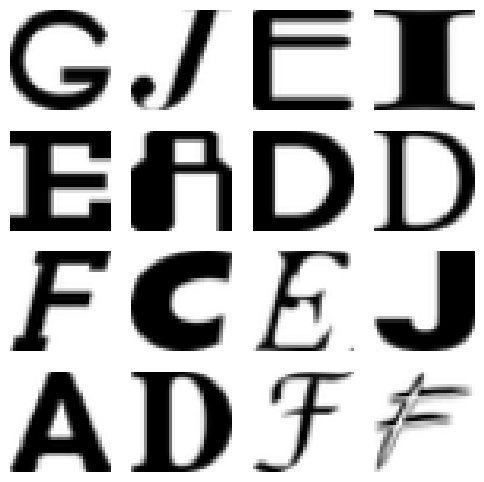

In [6]:
show_images(xb[:16], imsize=1.5)

In [7]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

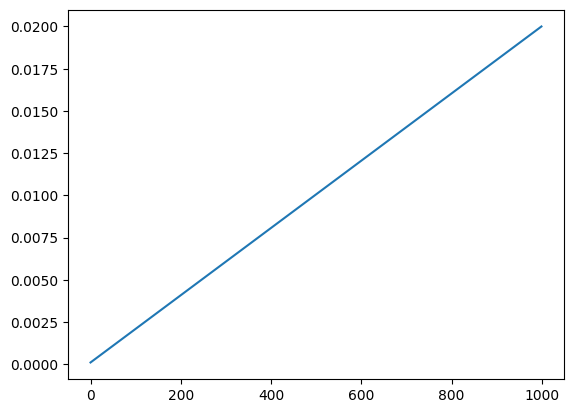

In [8]:
plt.plot(beta)

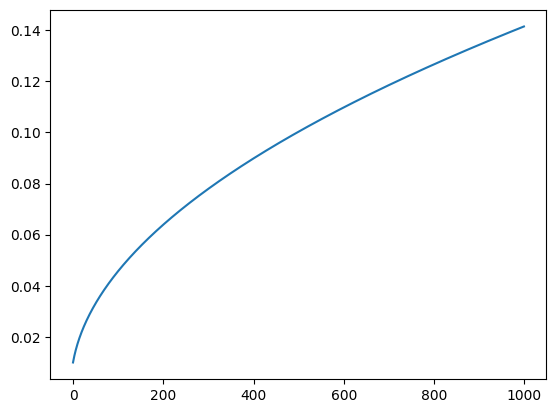

In [9]:
plt.plot(sigma)

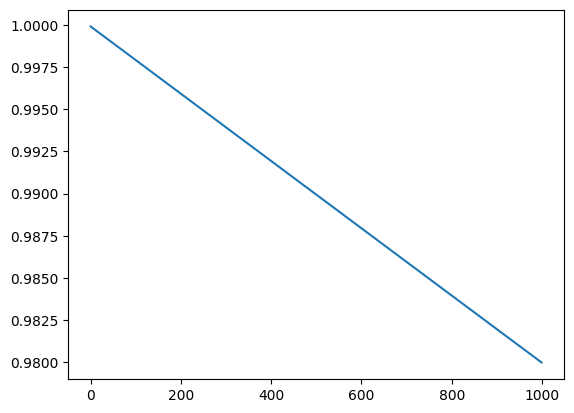

In [10]:
plt.plot(1 - beta)

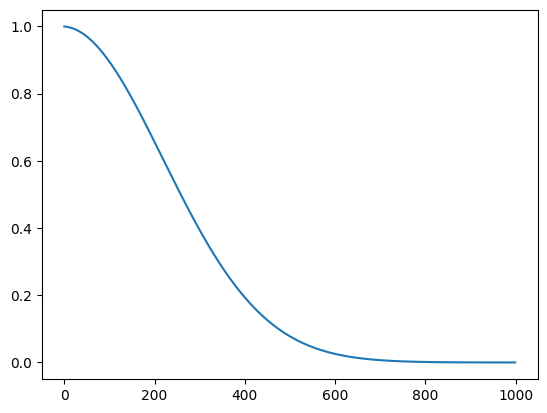

In [11]:
plt.plot(alphabar)

In [12]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt() * x0 + (1 - alphabar_t).sqrt() * epsilon
    return (xt, t.to(device)), epsilon

In [13]:
(xt, t), epsilon = noisify(xb[:25], alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295, 567, 706, 749, 876,  73, 111, 899,
        213, 541])

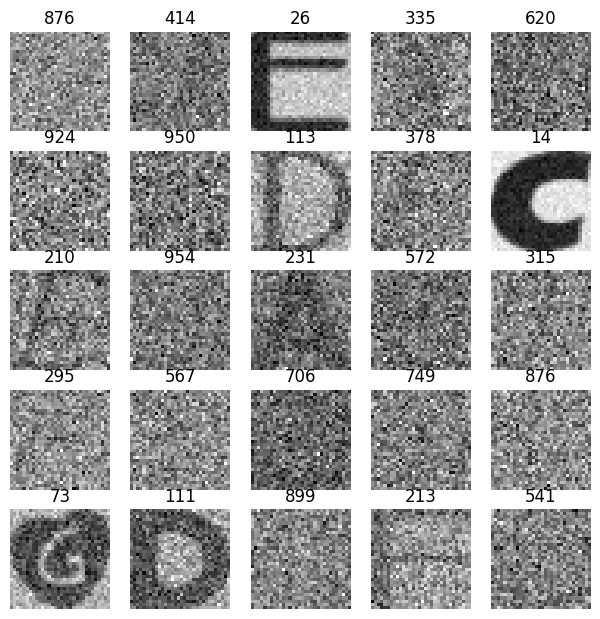

In [14]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [15]:
from diffusers import UNet2DModel

In [16]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for i in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alphabar_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1 - alphabar[t]
        betabar_t1 = 1 - alphabar_t1
        x_0_hat = ((x_t - betabar_t.sqrt() * learn.model((x_t, t_batch)))/ alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * alphabar_t1.sqrt() * (1 - alpha[t])/betabar_t + x_t * alpha[t].sqrt() * betabar_t1 / betabar_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [17]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta 
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.alphabar)
    def sample(self, model, sz): return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps)

In [18]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [19]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min = 0.0001, beta_max = 0.01)

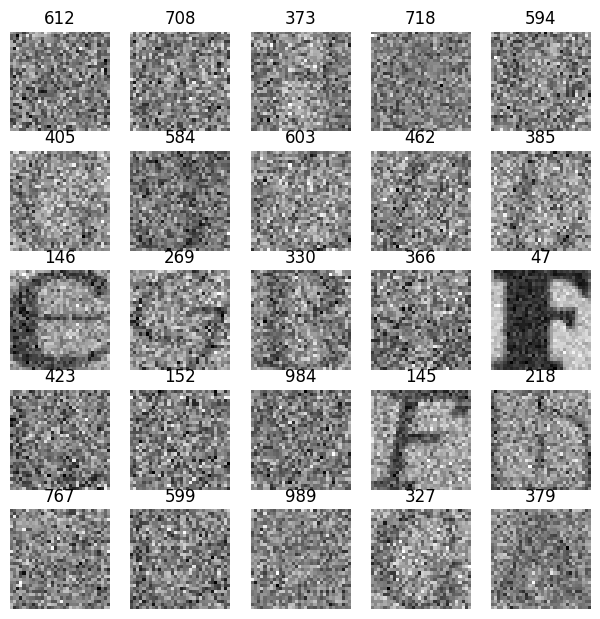

In [20]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])

(xt, t), epsilon = learn.batch
show_images(xt[:25], titles = fc.map_ex(t[:25], '{}'), imsize=1.5)

In [21]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [22]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [23]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)
    
    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()
    
    model.conv_out.weight.data.zero_()

In [24]:
init_ddpm(model)

In [25]:
opt_func = partial(optim.Adam, eps=1e-5)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.339,0,True
0.049,0,False
0.042,1,True
0.082,1,False
0.041,2,True
0.033,2,False
0.031,3,True
0.031,3,False
0.028,4,True
0.028,4,False


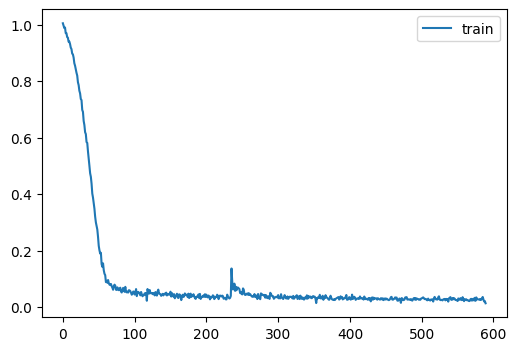

In [26]:
learn.fit(epochs)

## Sampling

In [27]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

TypeError: full() received an invalid combination of arguments - got (tuple, Tensor, dtype=torch.dtype, device=torch.device), but expected one of:
 * (tuple of ints size, Number fill_value, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, Number fill_value, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
show_images(samples[-1], figsize=(5, 5))

## Mixed Precision